In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None
                                )

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2021-08-07 21:00:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   324MB/s    in 0.3s    

2021-08-07 21:00:18 (324 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [4]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Added a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Added a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Added a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2021-08-07 21:00:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   238MB/s    in 0.6s    

2021-08-07 21:00:27 (238 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-08-07 21:00:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11

In [7]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'


train_horses_dir = os.path.join('/tmp/training/horses')
train_humans_dir = os.path.join('/tmp/training/humans')
validation_horses_dir = os.path.join('/tmp/validation/horses')
validation_humans_dir = os.path.join('/tmp/validation/humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))


500
527
128
128


In [8]:
# Added our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                  )
#The validation data is not augmented!
test_datagen = ImageDataGenerator(1./255 )

# Flowed training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150)
                                                    )     

# Flowed validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                         batch_size = 20,
                                                         class_mode = 'binary',
                                                         target_size = (150,150)
                                                         )



#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [9]:
# Stops when the training accuracy reached to 99.9%
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 50,
                    epochs = 3,
                    validation_steps = 12,
                    verbose = 1, # show animated bar
                    callbacks = [callbacks]
                    )


Epoch 1/3
50/50 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9544

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 45s 253ms/step - loss: 0.1123 - accuracy: 0.9544 - val_loss: 237.5055 - val_accuracy: 0.5042
Epoch 2/3
50/50 [==============================] - 12s 242ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 454.4015 - val_accuracy: 0.4917
Epoch 3/3
50/50 [==============================] - 11s 226ms/step - loss: 0.0313 - accuracy: 0.9909 - val_loss: 655.4062 - val_accuracy: 0.4833


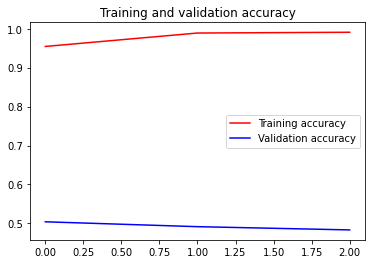

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()